In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np
from shapely.geometry import Point
import xlrd

from geopy.geocoders import Nominatim
from random import randint

from difflib import SequenceMatcher

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/.local/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [3]:
user_agent = 'user_me_{}'.format(randint(10000,99999))
geolocator = Nominatim(user_agent=user_agent)

In [4]:
geolocator

In [5]:
address = 'Santa Fe, Zapopan'
geolocator.geocode(address)

Location(Santa Fe, Zapopan, Jalisco, 45160, México, (20.7136061, -103.3922395, 0.0))

In [6]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [7]:
a = 'santa fe'
b = 'Santa Fe'
c = 'SANTA FE'

In [8]:
similar(a,c)

0.125

In [6]:
import xlrd

dir_grl = '../../data/raw/costo_vivienda/'

for file in os.listdir(dir_grl):

        if file.endswith('.xlsx'):
            if file == 'BD_SECTOR_INMOBILIARIO.xlsx':
                df = pd.read_excel(dir_grl+file, skiprows=4)
                
df.head(5)

,Inmueble,Precio,Municipio,Colonia
0,Departamento,6476224,Guadalajara,LADRON DE GUEVARA
1,Departamento,5390000,Zapopan,CAMINO REAL
2,Departamento,3677233,Guadalajara,JARDINES DEL BOSQUE
3,Departamento,7593583,Guadalajara,PROVIDENCIA
4,Casa,2500000,Zapopan,IXCATAN


In [7]:
df.Municipio.unique()

array(['Guadalajara', 'Zapopan', 'Tlajomulco', 'El Salto', 'Tlaquepaque',
       'Tonalá'], dtype=object)

In [10]:
idx = df.Colonia.isna()
df = df[~idx]
colonia = df.iloc[0]['Colonia']
municipio = df.iloc[0]['Municipio']

In [11]:
municipio

'Guadalajara'

In [12]:
address = colonia + ', '+ municipio
geocode = geolocator.geocode(address)
geocode

Location(Ladrón de Guevara, Guadalajara, Jalisco, 44158, México, (20.6760789, -103.3779083, 0.0))

In [13]:
geocode[1][0]

20.6760789

In [14]:
import numpy as np

df_test = df.iloc[:10].copy()

df['x'] = np.nan
df['y'] = np.nan

for i in range(len(df_test)):
    colonia = df_test.iloc[i]['Colonia']
    municipio = df_test.iloc[i]['Municipio']
    address = colonia + ', '+ municipio
    geocode = geolocator.geocode(address)
    
    if geocode is not None:
        x,y = geocode[1][1], geocode[1][0]
        df_test.loc[i,'x'] = x
        df_test.loc[i,'y'] = y

In [15]:
from shapely.geometry import Point

point_dict = {'geometry':[Point(x,y)]}
point_tmp = gpd.GeoDataFrame(
    pd.DataFrame.from_dict(point_dict), 
    geometry='geometry').set_crs("EPSG:4326")
buffer = point_tmp.to_crs("EPSG:6372").buffer(1500)
buffer = gpd.GeoDataFrame(buffer.to_crs("EPSG:4326"))
buffer.rename(columns={0:'geometry'}, inplace=True)

In [16]:
dir_grl = '../../data/external/colonia_amg/'
colonias = gpd.read_file(dir_grl+'colonias_amg.geojson', driver='GeoJSON')
print(colonias.shape)
colonias.head(2)

(2324, 10)


,ID,ENTIDAD,MUNICIPIO,NOMBRE,CLASIFICAC,CP,OTROS_CP,CONTROL,Geometry1_,geometry
0,1,14,41,LOMAS INDEPENDENCIA,1,44370,None,1,1=X<rg,"MULTIPOLYGON (((-103.32323 20.69386, -103.3226..."
1,2,14,41,POSTES CUATES,2,44350,None,2,1=X<rg,"MULTIPOLYGON (((-103.32296 20.69387, -103.3228..."


In [17]:
buffer_colonias = gpd.sjoin(buffer, colonias)
buffer_colonias.head(4)

,geometry,index_right,ID,ENTIDAD,MUNICIPIO,NOMBRE,CLASIFICAC,CP,OTROS_CP,CONTROL,Geometry1_
0,"POLYGON ((-103.40471 20.71782, -103.40477 20.7...",1686,3648,14,120,SANTA ISABEL,1,45110,None,133,1=X<Ks
0,"POLYGON ((-103.40471 20.71782, -103.40477 20.7...",745,1377,14,120,EL PRADO,2,45118,None,1683,"1=X<KT,"
0,"POLYGON ((-103.40471 20.71782, -103.40477 20.7...",747,1379,14,120,LOMAS DEL BOSQUE,2,45118,None,1685,"1=X<KT,"
0,"POLYGON ((-103.40471 20.71782, -103.40477 20.7...",1395,3111,14,120,PONTEVEDRA,23,45116,None,5001,1=X<Ks


In [19]:
colonia.lower()

'puerta de hierro'

In [18]:
point_colonia = gpd.sjoin(point_tmp, colonias)
point_colonia['NOMBRE'] = point_colonia['NOMBRE'].apply(lambda x: x.lower())
point_colonia.head(4)

,geometry,index_right,ID,ENTIDAD,MUNICIPIO,NOMBRE,CLASIFICAC,CP,OTROS_CP,CONTROL,Geometry1_
0,POINT (-103.41917 20.71769),1689,3651,14,120,puerta de hierro,2,45116,None,12047,1=X<Ks


In [20]:
buffer_colonias['NOMBRE'] = buffer_colonias['NOMBRE'].apply(lambda x: x.lower())

In [21]:
buffer_colonias['similarity'] = buffer_colonias['NOMBRE'].apply(lambda x: similar(colonia.lower(), x))

In [35]:
buffer_similar = buffer_colonias.sort_values('similarity', ascending=False).iloc[:3]
buffer_similar.reset_index(drop=True, inplace=True)
buffer_similar

,geometry,index_right,ID,ENTIDAD,MUNICIPIO,NOMBRE,CLASIFICAC,CP,OTROS_CP,CONTROL,Geometry1_,similarity
0,"POLYGON ((-103.40471 20.71782, -103.40477 20.7...",1689,3651,14,120,puerta de hierro,2,45116,None,12047,1=X<Ks,1.000000
1,"POLYGON ((-103.40471 20.71782, -103.40477 20.7...",1167,2672,14,120,puerta del valle,2,45140,None,4134,1=X<Kt5,0.687500
2,"POLYGON ((-103.40471 20.71782, -103.40477 20.7...",1068,2394,14,120,puerta de plata,2,45116,None,3710,1=X<Kt>,0.645161


In [23]:
point_similairty = similar(colonia.lower(), point_colonia.NOMBRE[0])
point_similairty

1.0

In [37]:
point_similairty = 0
if point_similairty >= buffer_colonias.similarity.max():
    id_colonia = point_colonia.iloc[0].ID
    print('here')
else:
    options = [x for x in buffer_similar.NOMBRE]
    options = [point_colonia.NOMBRE[0]] + options
    print(colonia.lower(), options)
    user_selection = input('Select, 0,1,2,3 or None')
    if user_selection != 'None':
        id_colonia = point_colonia.iloc[int(user_selection)-1].ID
        print(options[int(user_selection)])

puerta de hierro ['puerta de hierro', 'puerta de hierro', 'puerta del valle', 'puerta de plata']


Select, 0,1,2,3 or None 1


puerta de hierro


In [40]:
colonia = colonias.loc[colonias.ID==id_colonia,['ID','geometry']]
point_within_polygon = gpd.GeoDataFrame(geometry=colonia.representative_point())

In [42]:
colonia = colonia.to_crs("EPSG:6372")
colonia = colonia.buffer(1).reset_index().rename(columns={0: "geometry"})
colonia = colonia.to_crs("EPSG:4326")
poly_wkt = colonia.dissolve().geometry.to_wkt()[0]

In [44]:
schema = 'censo'
folder = 'censo_mza_centroid_2020'
query = f"SELECT cvegeo, geometry FROM {schema}.{folder} WHERE ST_Intersects(geometry, 'SRID=4326;{poly_wkt}')"
colonia_blocks = aup.gdf_from_query(query, geometry_col="geometry")

In [60]:
x = colonia_blocks.sample(1).geometry.x.values[0]
y = colonia_blocks.sample(1).geometry.y.values[0]

y


20.713033037492185

<AxesSubplot:>

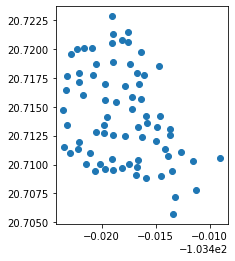

In [47]:
colonia_blocks.plot()

In [35]:
# crea centroide de la colonia
# descarga manzanas de la base de datos y asigna el punto de forma aleatoria
# extrae centroide de la manzana seleccionada
# crea geometría y la carga a la tabla

nan

## Putting it all together

In [2]:
user_agent = 'user_me_{}'.format(randint(10000,99999))
geolocator = Nominatim(user_agent=user_agent)

In [3]:
dir_grl = '../../data/raw/costo_vivienda/'

for file in os.listdir(dir_grl):

        if file.endswith('.xlsx'):
            if file == 'BD_SECTOR_INMOBILIARIO.xlsx':
                df = pd.read_excel(dir_grl+file, skiprows=4)

# abre gdf de colonias                
dir_grl = '../../data/external/colonia_amg/'
colonias = gpd.read_file(dir_grl+'colonias_amg.geojson', driver='GeoJSON')
colonias['NOMBRE'] = colonias['NOMBRE'].apply(lambda x: x.lower())

In [4]:
idx = df.Colonia.isna()
df = df[~idx]

# crea las columnas para guardar coordenadas de la venta
df['x'] = np.nan
df['y'] = np.nan

In [5]:
mun_dict = {'zapopan':120,
           'guadalajara':41,
           'tlaquepaque':99,
           'tonalá':102,
           'el salto':72,
           'zapotlanejo':124,
           'juanacatlán':53,
           'ixtlahuacán':46,
           'tlajomulco':98}

In [6]:

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [31]:
from tqdm import tqdm

# crea las columnas para guardar coordenadas de la venta
df['x'] = np.nan
df['y'] = np.nan

selection_dict = {'buffer':{},
                 'colonias':{}}

for i in tqdm(range(len(df)), position=0, leave=True):
    # itera y obtiene colonia, municipio y crea una direccion
    colonia = df.iloc[i]['Colonia']
    municipio = df.iloc[i]['Municipio']
    address = colonia + ', '+ municipio + ', Jalisco, Mexico'
    geocode = geolocator.geocode(address) # geocode
    
    # revisa si se obtuvieron datos
    if geocode is not None:
        x,y = geocode[1][1], geocode[1][0]
        
        # crea un punto con las coordenadas para estudiar el entorno
        point_dict = {'geometry':[Point(x,y)]}
        point_tmp = gpd.GeoDataFrame(
            pd.DataFrame.from_dict(point_dict), 
            geometry='geometry').set_crs("EPSG:4326")
        
        # buffer a partir del punto
        buffer = point_tmp.to_crs("EPSG:6372").buffer(1500)
        buffer = gpd.GeoDataFrame(buffer.to_crs("EPSG:4326"))
        buffer.rename(columns={0:'geometry'}, inplace=True)
        
        # obtiene las colonias dentro del buffer
        buffer_colonias = gpd.sjoin(buffer, colonias)
        
        # continua solo si hay colonias dentro del buffer
        if len(buffer_colonias) != 0:
            
            # analiza similitud del nombre de la colonia en la que cayó el punto
            # con el nombre de la colonia que se está buscando
            point_colonia = gpd.sjoin(point_tmp, colonias)
            # point_colonia['NOMBRE'] = point_colonia['NOMBRE'].apply(lambda x: x.lower())
            point_similairty = similar(colonia.lower(), point_colonia.NOMBRE[0])

            # analiza similitud del nombre de las colonias dentro del buffer
            # con el nombre de la colonia que se está buscando
            # buffer_colonias['NOMBRE'] = buffer_colonias['NOMBRE'].apply(lambda x: x.lower())
            buffer_colonias['similarity'] = buffer_colonias['NOMBRE'].apply(lambda x: similar(colonia.lower(), x))
            
            # filtra a los nombres más parecidos
            buffer_similar = buffer_colonias.sort_values('similarity', ascending=False).iloc[:3]
            buffer_similar.reset_index(drop=True, inplace=True)
            
            # primer analisis
            # comparacion enrte colonias del punto y buffer
            if point_similairty == 1:
                id_colonia = point_colonia.iloc[0].ID

            elif buffer_colonias.similarity.max() == 1:
                id_colonia = buffer_similar.iloc[0].ID
                

            else:                   

                options = [x for x in buffer_similar.NOMBRE]
                options = [point_colonia.NOMBRE[0]] + options

                if colonia in selection_dict['buffer'].keys():
                    id_colonia = buffer_similar.iloc[int(selection_dict['buffer'][colonia])-1].ID

                else:

                    print(colonia.lower(), options)

                    user_selection = input('Select: 0 for point value or: 1,2,3 for buffer values or None to skip')

                    if user_selection != 'None':
                        id_colonia = buffer_similar.iloc[int(user_selection)-1].ID
                        selection_dict['buffer'][colonia] = user_selection


                    else:
                        colonias_analisis = colonias.loc[colonias.MUNICIPIO==mun_dict[municipio.lower()]].copy()
                        # colonias_analisis['NOMBRE'] = colonias_analisis['NOMBRE'].apply(lambda x: x.lower())
                        colonias_analisis['similarity'] = colonias_analisis['NOMBRE'].apply(lambda x: similar(colonia.lower(), x))
                        colonias_similar = colonias_analisis.sort_values('similarity', ascending=False)
                        colonias_similar = colonias_similar.loc[colonias_similar.similarity>=0.6]
                        colonias_similar.reset_index(drop=True, inplace=True)

                        if colonias_similar.similarity.max() == 1:
                            id_colonia = colonias_similar.iloc[0].ID

                        else:

                            options = [x for x in colonias_similar.NOMBRE]

                            if colonia in selection_dict['colonias'].keys():
                                id_colonia = colonias_similar.iloc[int(selection_dict['colonias'][colonia])-1].ID

                            else:

                                print(colonia.lower(), options)

                                user_selection = input('Select: 1,2,3...n for colonias values or None to skip')

                                if user_selection != 'None':
                                    id_colonia = colonias_similar.iloc[int(user_selection)-1].ID
                                    selection_dict['colonias'][colonia] = user_selection

                                else:
                                    continue

            colonia_gdf = colonias.loc[colonias.ID==id_colonia,['ID','geometry']]

            # point_within_polygon = gpd.GeoDataFrame(geometry=colonia.representative_point())

            colonia_gdf = colonia_gdf.to_crs("EPSG:6372")
            buffer_colonia = gpd.GeoDataFrame(
                gpd.GeoDataFrame(
                    colonia_gdf.buffer(1).reset_index(drop=True))).rename(columns={0:'geometry'})
            buffer_colonia = buffer_colonia.to_crs("EPSG:4326")
            poly_wkt = buffer_colonia.dissolve().geometry.to_wkt()[0]

            schema = 'censo'
            folder = 'censo_mza_centroid_2020'
            query = f"SELECT cvegeo, geometry FROM {schema}.{folder} WHERE ST_Intersects(geometry, 'SRID=4326;{poly_wkt}')"
            colonia_blocks = aup.gdf_from_query(query, geometry_col="geometry")

            if len(colonia_blocks) != 0:

                rndm_colonia_block = colonia_blocks.sample(1)

                x_colonia = rndm_colonia_block.geometry.x.values[0]
                y_colonia = rndm_colonia_block.geometry.y.values[0]

                df_test.loc[i,'x'] = x_colonia

                df_test.loc[i,'y'] = y_colonia

  0%|                                                                                                                                              | 5/9601 [00:11<6:17:59,  2.36s/it]

cima real ['colinas del rey', 'hacienda del valle', 'la cima', 'colinas del rey']


Select: 0 for point value or: 1,2,3 for buffer values or None to skip None


  0%|▏                                                                                                                                            | 15/9601 [00:42<6:46:37,  2.55s/it]

los pinos ['santa ana tepetitlan', 'villas perisur', 'lomas del fortin', 'el fortin']


Select: 0 for point value or: 1,2,3 for buffer values or None to skip None


  0%|▏                                                                                                                                           | 16/9601 [00:52<12:13:04,  4.59s/it]

los pinos ['santa ana tepetitlan', 'villas perisur', 'lomas del fortin', 'el fortin']


Select: 0 for point value or: 1,2,3 for buffer values or None to skip None


  0%|▎                                                                                                                                           | 24/9601 [03:49<15:28:05,  5.81s/it]

bosques de santa anita ['condominio campo de golf santa anita', 'arbolada bosques de santa anita', 'real de santa anita', 'villas de santa anita']


Select: 0 for point value or: 1,2,3 for buffer values or None to skip 1


  0%|▍                                                                                                                                           | 26/9601 [04:03<15:47:34,  5.94s/it]

bosques de san isidro (las cañadas) ['bosques de san isidro (las ca�adas)', 'bosques de san isidro (las ca�adas)', 'lomas del centinela', 'canteras del centinela']


Select: 0 for point value or: 1,2,3 for buffer values or None to skip 0


  0%|▍                                                                                                                                           | 29/9601 [04:46<23:44:24,  8.93s/it]

mirador del bosque ['fraccionamiento mirador del bosque', 'fraccionamiento mirador del bosque', 'fraccionamiento albaterra']


Select: 0 for point value or: 1,2,3 for buffer values or None to skip 0


  0%|▌                                                                                                                                            | 39/9601 [05:13<7:02:09,  2.65s/it]

felipe angeles ['centro', 'laureles', 'el pedregal', 'mesa de los laureles']


Select: 0 for point value or: 1,2,3 for buffer values or None to skip None


  1%|▋                                                                                                                                            | 49/9601 [05:38<5:56:56,  2.24s/it]

ciudad aztlan ['tonala centro', 'la guadalupana', 'colinas de altamira', 'la alberca']


Select: 0 for point value or: 1,2,3 for buffer values or None to skip None


  1%|█▎                                                                                                                                           | 92/9601 [07:21<6:13:29,  2.36s/it]

san diego ['la purisima', 'los ciruelos', 'los ciruelos', 'silos']


Select: 0 for point value or: 1,2,3 for buffer values or None to skip None


  1%|█▋                                                                                                                                          | 114/9601 [08:37<5:35:22,  2.12s/it]

centro ['arroyo seco', 'san arturo', 'el mante', 'santa maria']


Select: 0 for point value or: 1,2,3 for buffer values or None to skip None


  1%|█▌                                                                                                                                   | 116/9601 [4:16:55<8245:50:12, 3129.68s/it]

horizontes de tlaquepaque ['horizonte el tapatio', 'horizonte el tapatio', 'jardines del tapatio', 'paisajes del tapatio']


Select: 0 for point value or: 1,2,3 for buffer values or None to skip None


  1%|█▊                                                                                                                                       | 131/9601 [4:17:38<45:10:47, 17.17s/it]

felipe angeles ['centro', 'laureles', 'el pedregal', 'mesa de los laureles']


Select: 0 for point value or: 1,2,3 for buffer values or None to skip None


  1%|██                                                                                                                                        | 140/9601 [4:18:36<9:15:39,  3.52s/it]

la purisima ['hacienda santa fe', 'las luces', 'la concha jardin residencial', 'geovillas la arbolada']


Select: 0 for point value or: 1,2,3 for buffer values or None to skip None


  2%|██▏                                                                                                                                       | 154/9601 [4:20:11<5:31:21,  2.10s/it]

francisco silva romero ['la soledad', 'san francisco', 'paseos del valle', 'brisas del nilo']


Select: 0 for point value or: 1,2,3 for buffer values or None to skip None


  2%|██▏                                                                                                                                      | 156/9601 [4:21:07<33:39:10, 12.83s/it]

prados de la cañada ['prados de la ca�ada', 'prados de la ca�ada', 'san francisco de la soledad', 'san francisco de la soledad']


Select: 0 for point value or: 1,2,3 for buffer values or None to skip 0


  2%|██▍                                                                                                                                       | 167/9601 [4:21:30<4:25:03,  1.69s/it]

de san martin ['san martin de las flores de arriba', 'bosques de san martin', 'lomas de san pedrito', 'san pedrito']


Select: 0 for point value or: 1,2,3 for buffer values or None to skip 0


  2%|██▌                                                                                                                                       | 180/9601 [4:22:33<6:17:28,  2.40s/it]

san diego ['la purisima', 'los ciruelos', 'los ciruelos', 'silos']


Select: 0 for point value or: 1,2,3 for buffer values or None to skip None


  2%|██▋                                                                                                                                       | 186/9601 [4:23:10<6:58:21,  2.67s/it]

villas de tesistan ['villas de la loma', 'villas del valle', 'villas de la loma', 'lomas de san gonzalo']


Select: 0 for point value or: 1,2,3 for buffer values or None to skip None


  2%|██▋                                                                                                                                       | 191/9601 [4:23:38<8:52:41,  3.40s/it]

villas del bosque ['la guadalupana', 'lomas de san miguel', 'luis alonso', 'jose vasconcelos']


Select: 0 for point value or: 1,2,3 for buffer values or None to skip None


  2%|███                                                                                                                                       | 211/9601 [4:24:30<5:51:00,  2.24s/it]

beatriz hernandez ['zona centro', 'barragan hernandez', 'obrera', 'la perla']


Select: 0 for point value or: 1,2,3 for buffer values or None to skip None


  2%|███                                                                                                                                      | 212/9601 [4:24:40<12:05:12,  4.63s/it]

beatriz hernandez ['zona centro', 'barragan hernandez', 'obrera', 'la perla']


Select: 0 for point value or: 1,2,3 for buffer values or None to skip None


  2%|███                                                                                                                                     | 218/9601 [4:25:02<190:07:55, 72.95s/it]


TypeError: unhashable type: 'Series'

In [7]:
from tqdm import tqdm

selection_dict = {'buffer':{},
                  'point':{},
                 'colonias':{},
                 'none':{}}

selection_dict = {'buffer': {},
 'point': {'MIRADOR DEL BOSQUE': ' 1'},
 'colonias': {'MAGAÑA': ' 1'},
 'none': {}}

skip_list = []

df_analysis = df.loc[df.x.isna()]

for i in tqdm(df_analysis.index.values, position=0, leave=True):
    
    if i in skip_list:
        continue
    
    # itera y obtiene colonia, municipio y crea una direccion
    colonia = df_analysis.loc[df_analysis.index==i,'Colonia'].values[0]
    municipio = df_analysis.loc[df_analysis.index==i,'Municipio'].values[0]
    address = colonia + ', '+ municipio + ', Jalisco, Mexico'
    
    try:
        geocode = geolocator.geocode(address) # geocode
    except:
        skip_list.append(i)
        continue
    
    # revisa si se obtuvieron datos
    if geocode is not None:
        x,y = geocode[1][1], geocode[1][0]
        
        # crea un punto con las coordenadas para estudiar el entorno
        point_dict = {'geometry':[Point(x,y)]}
        point_tmp = gpd.GeoDataFrame(
            pd.DataFrame.from_dict(point_dict), 
            geometry='geometry').set_crs("EPSG:4326")
        
        # buffer a partir del punto
        buffer = point_tmp.to_crs("EPSG:6372").buffer(1500)
        buffer = gpd.GeoDataFrame(buffer.to_crs("EPSG:4326"))
        buffer.rename(columns={0:'geometry'}, inplace=True)
        
        # obtiene las colonias dentro del buffer
        buffer_colonias = gpd.sjoin(buffer, colonias)
        
        # continua solo si hay colonias dentro del buffer
        if len(buffer_colonias) != 0:
            
            # analiza similitud del nombre de la colonia en la que cayó el punto
            # con el nombre de la colonia que se está buscando
            point_colonia = gpd.sjoin(point_tmp, colonias)
            try:
                point_colonia = point_colonia.reset_index(drop=True).loc[0]
            except:
                continue
            point_similairty = similar(colonia.lower(), point_colonia.NOMBRE)

            # analiza similitud del nombre de las colonias dentro del buffer
            # con el nombre de la colonia que se está buscando
            buffer_colonias['similarity'] = buffer_colonias['NOMBRE'].apply(lambda x: similar(colonia.lower(), x))
            
            # filtra a los nombres más parecidos
            buffer_similar = buffer_colonias.sort_values('similarity', ascending=False).iloc[:3]
            buffer_similar.reset_index(drop=True, inplace=True)
            
            colonias_analisis = colonias.loc[colonias.MUNICIPIO==mun_dict[municipio.lower()]].copy()
            # colonias_analisis['NOMBRE'] = colonias_analisis['NOMBRE'].apply(lambda x: x.lower())
            colonias_analisis['similarity'] = colonias_analisis['NOMBRE'].apply(lambda x: similar(colonia.lower(), x))
            colonias_similar = colonias_analisis.sort_values('similarity', ascending=False)
            colonias_similar = colonias_similar.loc[colonias_similar.similarity>=0.65]
            colonias_similar.reset_index(drop=True, inplace=True)
            
            # primer analisis
            # comparacion enrte colonias del punto y buffer
            if point_similairty >= 0.90:
                id_colonia = point_colonia.ID
                
            # analiza si hay un nombre dentro de colonias buffer
            # que sea igual a la colonia que se busca
            elif buffer_colonias.similarity.max() >= 0.90:
                id_colonia = buffer_similar.iloc[0].ID
            
            # analiza si hay un nombre dentro de los nombres de colonias
            # que sea igual a la colonia que se busca
            elif colonias_similar.similarity.max() >= 0.90:
                id_colonia = colonias_similar.iloc[0].ID
                
            # ofrece opciones al usuario
            else:
                options = {}
                options['buffer'] = [x for x in buffer_similar.NOMBRE]
                options['point'] = [point_colonia.NOMBRE]
                options['colonias'] = [x for x in colonias_similar.NOMBRE]
                
                # analiza si es una colonia sobre la que ya se había hecho una seleccion
                # por usuario
                if colonia in selection_dict['buffer'].keys():
                    id_colonia = buffer_similar.iloc[int(selection_dict['buffer'][colonia])-1].ID
                    
                elif colonia in selection_dict['point'].keys():
                    id_colonia = point_colonia.ID
                
                elif colonia in selection_dict['colonias'].keys():
                    id_colonia = colonias_similar.iloc[int(selection_dict['colonias'][colonia])-1].ID
                
                elif colonia in selection_dict['none'].keys():
                    continue
                
                # si no se ha preguntado sobre esa colonia se hace la pregunta
                else:

                    print(colonia.lower(), options)

                    user_selection = input('Write the option (buffer, point, colonias) , and the number (1,2,3..n) or none to skip')
                    select_level = user_selection.split(',')[0]
                    select_id = user_selection.split(',')[1]
                        
                    # guarda la seleccion del usuario
                    selection_dict[select_level][colonia] = select_id

                    # selecciona la colonia de acuerdo con la seleccion de usuario
                    if select_level == 'buffer':
                        id_colonia = buffer_similar.iloc[int(select_id)-1].ID
                    
                    elif select_level == 'point':
                        id_colonia = point_colonia.ID
                        
                    elif select_level == 'colonias':
                        id_colonia = colonias_similar.iloc[int(select_id)-1].ID
                        
                    elif select_level == 'none':
                        continue
                       

            colonia_gdf = colonias.loc[colonias.ID==id_colonia,['ID','geometry']]

            colonia_gdf = colonia_gdf.to_crs("EPSG:6372")
            buffer_colonia = gpd.GeoDataFrame(
                gpd.GeoDataFrame(
                    colonia_gdf.buffer(1).reset_index(drop=True))).rename(columns={0:'geometry'})
            buffer_colonia = buffer_colonia.to_crs("EPSG:4326")
            poly_wkt = buffer_colonia.dissolve().geometry.to_wkt()[0]

            schema = 'censo'
            folder = 'censo_mza_centroid_2020'
            query = f"SELECT cvegeo, geometry FROM {schema}.{folder} WHERE ST_Intersects(geometry, 'SRID=4326;{poly_wkt}')"
            colonia_blocks = aup.gdf_from_query(query, geometry_col="geometry")
            
            # analiza si se obtuvieron manzanas dentro de la colonia
            if len(colonia_blocks) != 0:

                rndm_colonia_block = colonia_blocks.sample(1)

                x_colonia = rndm_colonia_block.geometry.x.values[0]
                y_colonia = rndm_colonia_block.geometry.y.values[0]

                df.loc[df.index==i,'x'] = x_colonia

                df.loc[df.index==i,'y'] = y_colonia
                
    else:
        skip_list.append(i)
            

 40%|████████████████                        | 3845/9601 [2:34:13<3:52:35,  2.42s/it]

dr atlas {'buffer': ['san elias', 'alcalde barranquitas', 'jardines alcalde'], 'point': ['independencia'], 'colonias': ['dr atl', 'atlas']}


Write the option (buffer, point, colonias) , and the number (1,2,3..n) or none to skip colonias, 1


 94%|███████████████████████████████████████▎  | 8985/9601 [5:58:42<27:03,  2.64s/it]

el alamo {'buffer': ['la aurora', 'el retiro', 'analco'], 'point': ['zona centro'], 'colonias': ['el zalate', 'el zalate', 'valle del alamo', 'valle del alamo']}


Write the option (buffer, point, colonias) , and the number (1,2,3..n) or none to skip colonias, 3


100%|██████████████████████████████████████████| 9601/9601 [6:33:45<00:00,  2.46s/it]


In [71]:
selection_dict

{'buffer': {},
 'point': {'MIRADOR DEL BOSQUE': ' 1'},
 'colonias': {'MAGAÑA': ' 1'},
 'none': {}}

In [8]:
selection_dict = {'buffer': {},
 'point': {'MIRADOR DEL BOSQUE': ' 1'},
 'colonias': {'MAGAÑA': ' 1'},
 'none': {}}

skip_list = []

df_analysis = df.loc[df.x.isna()]

for i in tqdm(df_analysis.index.values, position=0, leave=True):
    
    # itera y obtiene colonia, municipio y crea una direccion
    colonia = df_analysis.loc[df_analysis.index==i,'Colonia'].values[0]
    municipio = df_analysis.loc[df_analysis.index==i,'Municipio'].values[0]
    
    colonias_analisis = colonias.loc[colonias.MUNICIPIO==mun_dict[municipio.lower()]].copy()
    # colonias_analisis['NOMBRE'] = colonias_analisis['NOMBRE'].apply(lambda x: x.lower())
    colonias_analisis['similarity'] = colonias_analisis['NOMBRE'].apply(lambda x: similar(colonia.lower(), x))
    colonias_similar = colonias_analisis.sort_values('similarity', ascending=False)
    colonias_similar = colonias_similar.loc[colonias_similar.similarity>=0.65]
    colonias_similar.reset_index(drop=True, inplace=True)
    
    # analiza si hay un nombre dentro de los nombres de colonias
    # que sea igual a la colonia que se busca
    if colonias_similar.similarity.max() >= 0.90:
        id_colonia = colonias_similar.iloc[0].ID
        
        colonia_gdf = colonias.loc[colonias.ID==id_colonia,['ID','geometry']]

        colonia_gdf = colonia_gdf.to_crs("EPSG:6372")
        buffer_colonia = gpd.GeoDataFrame(
            gpd.GeoDataFrame(
                colonia_gdf.buffer(1).reset_index(drop=True))).rename(columns={0:'geometry'})
        buffer_colonia = buffer_colonia.to_crs("EPSG:4326")
        poly_wkt = buffer_colonia.dissolve().geometry.to_wkt()[0]

        schema = 'censo'
        folder = 'censo_mza_centroid_2020'
        query = f"SELECT cvegeo, geometry FROM {schema}.{folder} WHERE ST_Intersects(geometry, 'SRID=4326;{poly_wkt}')"
        colonia_blocks = aup.gdf_from_query(query, geometry_col="geometry")

        # analiza si se obtuvieron manzanas dentro de la colonia
        if len(colonia_blocks) != 0:

            rndm_colonia_block = colonia_blocks.sample(1)

            x_colonia = rndm_colonia_block.geometry.x.values[0]
            y_colonia = rndm_colonia_block.geometry.y.values[0]

            df.loc[df.index==i,'x'] = x_colonia

            df.loc[df.index==i,'y'] = y_colonia
    
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1452/1452 [58:24<00:00,  2.41s/it]


In [9]:
sum(df.x.isna())

303

In [12]:
dir_grl = '../../data/processed/costo_vivienda/'
df.to_csv(dir_grl+'2019_Venta_BD_SECTORINMOBILIARIO_coord.csv')